# Part 0: Dataloader and Visualizations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash

wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
tar -xf VOCtrainval_06-Nov-2007.tar

wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar 
tar -xf VOCtest_06-Nov-2007.tar

cd "/content/VOCdevkit/VOC2007"
mkdir "selective_search_data"

cd "/content/VOCdevkit/VOC2007/selective_search_data"

pip install --upgrade --no-cache-dir gdown

gdown --id "1jYjlspLhzT8zyJG02BtScCu1qUuC3fSq"
gdown --id "1ygKvdSdzaasiJA8alRVFaR80VhuadB9v"

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=8b8e6f9f9d3c0807b27aafe9884d6aa16cfc7e326267277a1270089e066221e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-6cam9l6c/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


--2022-03-23 16:09:53--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

     0K .......... .......... .......... .......... ..........  0%  194K 38m31s
    50K .......... .......... .......... .......... ..........  0%  389K 28m53s
   100K .......... .......... .......... .......... ..........  0% 98.3M 19m17s
   150K .......... .......... .......... .......... ..........  0% 74.8M 14m29s
   200K .......... .......... .......... .......... ..........  0%  391K 15m25s
   250K .......... .......... .......... .......... ..........  0% 68.2M 12m52s
   300K .......... .......... .......... .......... ..........  0% 95.6M 11m2s
   350K .......... .......... .......... .....

In [3]:
%cd drive/MyDrive/spring22/16824/hw2

/content/drive/MyDrive/spring22/16824/hw2


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.7 MB 8.8 MB/s 
     |████████████████████████████████| 181 kB 43.0 MB/s 
     |████████████████████████████████| 144 kB 34.5 MB/s 
     |████████████████████████████████| 63 kB 514 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=420ad39a9babda0e757489fe2084c6869d023eecc62a3f21d263d0ba5b191885
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [5]:
%load_ext autoreload
%autoreload 2

import torch
import wandb
import scipy.io

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from voc_dataset import VOCDataset

from PIL import Image

from utils import *

USE_WANDB = True

## Editing the Dataloader
The first part of the assignment involves editing the dataloader so that we can access bounding-box proposals as well as the ground-truth bounding boxes. The ground truth bounding box can be accessed through the VOC Dataset annotations itself. Unsupervised bounding box proposals are obtained through methods such as [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/UijlingsIJCV2013.pdf).

Since Selective Search is slow to run on each image, we have pre-computed the bounding box proposals. You should be able to access the `.mat` files using `scipy.io.loadmat('file.mat')`. Feel free to experiment with the data in the files to figure out the number of proposals per image, their scores, etc.

Your task is to change the dataloader to obtain the ground-truth bounding boxes, as well as the proposed bounding boxes for each image. Returning a dictionary would be convenient here. For the bounding boxes, using the relative positions is usually a better idea since they are invariant to changes in the size of the image.

In [8]:
# Load the Dataset - items at a particular index can be accesed by usual indexing notation (dataset[idx])
dataset = VOCDataset('trainval', top_n=10, perform_transforms=False, return_gt=True)

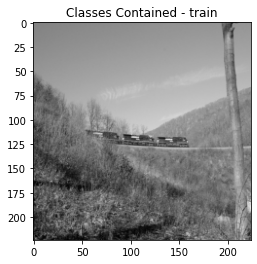

In [9]:
#TODO: get the image information from index 2020
idx = 2020

input = dataset[idx]

plt.title('Classes Contained - ' + \
          ', '.join([dataset.get_class_name(i) for i in input['gt_classes']]))
plt.imshow(input['image'].permute(1, 2, 0))
plt.show()

## Wandb Init and Logging
Initialize a Weights and Biases project, and convert the image tensor to a PIL image and plot it (check `utils.py` for helper functions).

You can use [this](https://docs.wandb.ai/library/log) as a reference for logging syntax.

In [10]:
if USE_WANDB:
    wandb.init(project="vlr2", reinit=True) # 0b13cc6cbf1facb7781763a80046416f0d2ee7f3

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


See this block as an example of plotting the ground truth box for an image.

In [ ]:
class_id_to_label = dict(enumerate(dataset.CLASS_NAMES))

original_image = tensor_to_PIL(input['image'], inverse_norm_required=False)
gt_labels = input['gt_classes']
gt_boxes = input['gt_boxes']

Check the `get_box_data` function in `utils.py` and understand how it is being used. Log the image with the GT bounding box on wandb.
After, this you should be able to easily plot the top 10 bounding proposals as well.

In [ ]:
rois = input['rois'].reshape(-1, 4)

rois = rois.tolist()

nums = range(len(rois)) # placeholder for names of proposals

gt_image = wandb.Image(original_image, boxes={
                  "predictions": {
                      "box_data": get_box_data(gt_labels, gt_boxes),
                      "class_labels": class_id_to_label,
                  },
              })

rois_image = wandb.Image(original_image, boxes={
                  "predictions": {
                      "box_data": get_box_data(list(nums), rois),
                      "class_labels": {i: str(i) for i in nums},
                  },
              })

wandb.log({"Ground Truth": gt_image})
wandb.log({"Region Proposals": rois_image})